In [32]:
import os
import pickle
import glob

import pandas as pd
import numpy as np
import xarray as xr
import scipy.stats as st
import matplotlib.pyplot as plt

import npc_lims
from npc_sessions import DynamicRoutingSession
from dynamic_routing_analysis import spike_utils, decoding_utils

%matplotlib widget


In [ ]:
# find sessions
Templeton_ephys_sessions = tuple(s for s in npc_lims.get_session_info(is_ephys=True, is_uploaded=True, is_annotated=True) 
                                if s.project=='TempletonPilotSession')

In [ ]:
Templeton_ephys_sessions

In [105]:
# sel_session = Templeton_ephys_sessions[4]
# sel_session = '670180_2023-07-26'
sel_session = '662892_2023-08-24'
session = DynamicRoutingSession(sel_session)
trials=pd.read_parquet(
            npc_lims.get_cache_path('trials',session.id,version='v0.0.173')
        )
units=pd.read_parquet(
            npc_lims.get_cache_path('units',session.id,version='v0.0.173')
        )


In [ ]:
# if not a DR session, make a false context label


In [3]:
# bin spike times (aligned to trials vs. not aligned to trials)
binsize=0.5
timebin_da,timebins_table=spike_utils.make_neuron_timebins_matrix(units, trials, binsize, generate_context_labels=True)

C:\Users\ethan.mcbride\Code\dynamic_routing_analysis\src\dynamic_routing_analysis\spike_utils.py:184: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['is_context_switch'].iloc[context_switches]=True


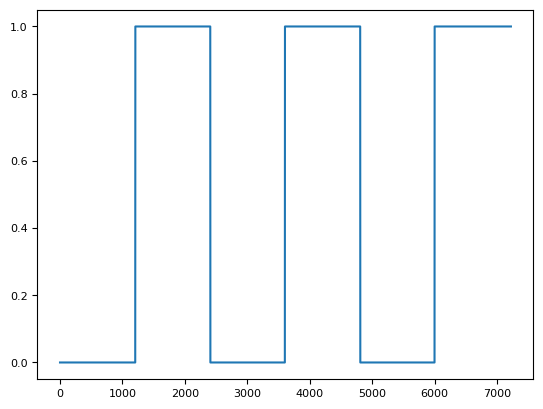

In [4]:
fig,ax=plt.subplots()
ax.plot(timebins_table['is_vis_context'])

In [15]:
unit_context_corr=np.full((len(units['unit_id'])),np.nan)
for uu,unit_id in enumerate(units['unit_id']):
    unit_context_corr[uu]=np.corrcoef(timebins_table['is_vis_context'],timebin_da.sel(unit_id=unit_id).values)[0,1]

(array([  1.,   0.,   1.,   1.,   0.,   3.,   0.,   6.,   0.,   6.,   8.,
          9.,  18.,  20.,   7.,  18.,  29.,  39.,  34.,  49.,  75.,  80.,
         89., 126., 140., 198., 225., 216., 211., 197., 161., 104.,  99.,
         76.,  53.,  48.,  33.,  23.,  20.,  13.,  23.,   9.,   9.,   5.,
          6.,   2.,   3.,   3.,   0.,   1.]),
 array([-0.42545747, -0.40956475, -0.39367203, -0.37777931, -0.36188659,
        -0.34599386, -0.33010114, -0.31420842, -0.2983157 , -0.28242298,
        -0.26653025, -0.25063753, -0.23474481, -0.21885209, -0.20295937,
        -0.18706664, -0.17117392, -0.1552812 , -0.13938848, -0.12349576,
        -0.10760303, -0.09171031, -0.07581759, -0.05992487, -0.04403215,
        -0.02813942, -0.0122467 ,  0.00364602,  0.01953874,  0.03543146,
         0.05132419,  0.06721691,  0.08310963,  0.09900235,  0.11489507,
         0.1307878 ,  0.14668052,  0.16257324,  0.17846596,  0.19435868,
         0.21025141,  0.22614413,  0.24203685,  0.25792957,  0.27382229,
 

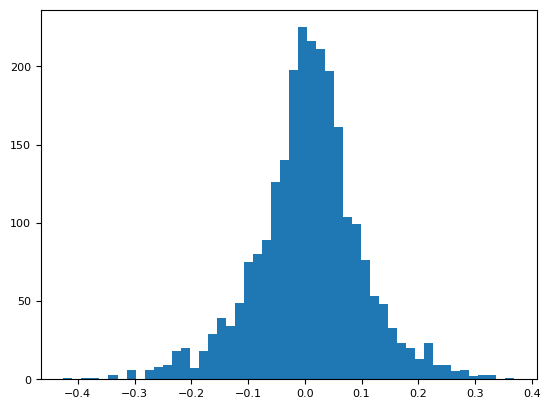

In [18]:
fig,ax=plt.subplots()
ax.hist(unit_context_corr[~np.isnan(unit_context_corr)],bins=50)

In [38]:
60/0.025

2400.0

In [56]:
# vary by binsize
bin_sizes=[0.01,0.025,0.05,0.1,0.2,0.5,1,5]

corr_by_binzise={}
corr_p_by_binzise={}

for binsize in bin_sizes:
    timebin_da,timebins_table=spike_utils.make_neuron_timebins_matrix(units, trials, binsize, generate_context_labels=True)
    
    unit_context_corr=np.full((len(units['unit_id'])),np.nan)
    unit_context_corr_p=np.full((len(units['unit_id'])),np.nan)
    for uu,unit_id in enumerate(units['unit_id']):
        timebindata=timebin_da.sel(unit_id=unit_id).values
        time_idx=np.arange(0,len(timebindata),np.max(bin_sizes)/binsize).astype(int)
        unit_context_corr[uu],unit_context_corr_p[uu]=st.pearsonr(timebins_table['is_vis_context'].iloc[time_idx],timebindata[time_idx])

    corr_by_binzise[binsize]=unit_context_corr
    corr_p_by_binzise[binsize]=unit_context_corr_p

C:\Users\ethan.mcbride\Code\dynamic_routing_analysis\src\dynamic_routing_analysis\spike_utils.py:184: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['is_context_switch'].iloc[context_switches]=True
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
C:\Users\ethan.mcbride\Code\dynamic_routing_analysis\src\dynamic_routing_analysis\spike_utils.py:184: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['is_context_switch'].iloc[context_switches]=

In [40]:
time_idx

array([     0.,   2400.,   4800.,   7200.,   9600.,  12000.,  14400.,
        16800.,  19200.,  21600.,  24000.,  26400.,  28800.,  31200.,
        33600.,  36000.,  38400.,  40800.,  43200.,  45600.,  48000.,
        50400.,  52800.,  55200.,  57600.,  60000.,  62400.,  64800.,
        67200.,  69600.,  72000.,  74400.,  76800.,  79200.,  81600.,
        84000.,  86400.,  88800.,  91200.,  93600.,  96000.,  98400.,
       100800., 103200., 105600., 108000., 110400., 112800., 115200.,
       117600., 120000., 122400., 124800., 127200., 129600., 132000.,
       134400., 136800., 139200., 141600., 144000.])

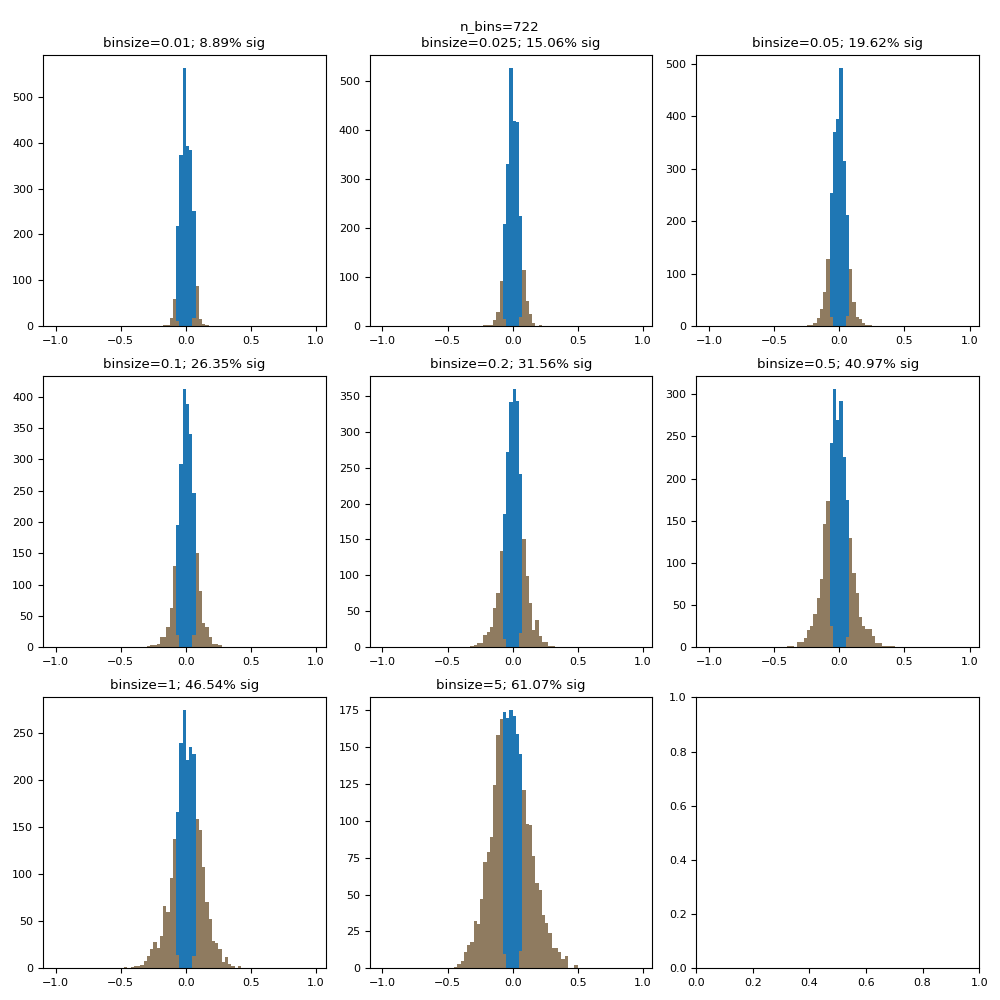

In [57]:
n_bins=len(np.arange(0,len(timebindata),np.max(bin_sizes)/binsize).astype(int))

p_thresh=0.05
xbins=np.arange(-1,1,0.025)
pct_sig=[]
fig,ax=plt.subplots(3,3,figsize=(10,10))
ax=ax.flatten()
for ix,xx in enumerate(corr_by_binzise):
    ax[ix].hist(corr_by_binzise[xx][~np.isnan(corr_by_binzise[xx])],bins=xbins,label=xx)
    ax[ix].hist(corr_by_binzise[xx][corr_p_by_binzise[xx]<p_thresh],bins=xbins,label=xx,alpha=0.5)
    temp_pct_sig=np.round(np.sum(corr_p_by_binzise[xx]<p_thresh)/len(corr_p_by_binzise[xx])*100,decimals=2)
    ax[ix].set_title('binsize='+str(xx)+'; '+str(temp_pct_sig)+'% sig')
# ax.legend()

fig.suptitle('n_bins='+str(n_bins))
fig.tight_layout()

230

Text(0.5, 1.0, 'r=0.424')

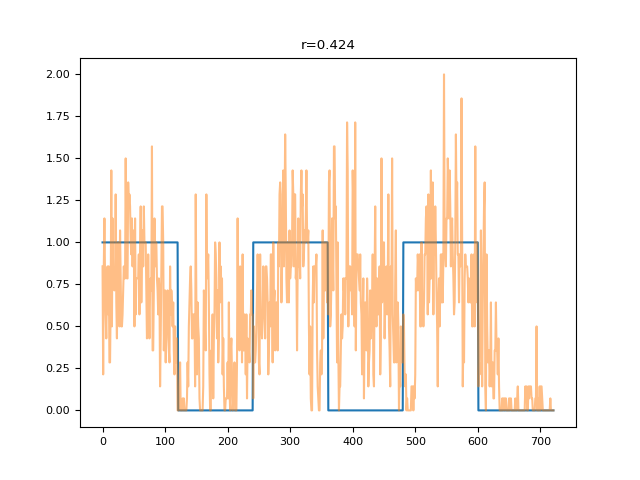

In [66]:

sel_unit_idx=np.where(np.abs(unit_context_corr)>0.4)[0][0]
binned_spikes=timebin_da.sel(unit_id=units['unit_id'].iloc[sel_unit_idx]).values

fig,ax=plt.subplots()
ax.plot(timebins_table['is_vis_context'])
ax.plot(binned_spikes/(np.max(binned_spikes)/2),alpha=0.5)
ax.set_title('r='+str(np.round(unit_context_corr[sel_unit_idx],decimals=3)))


In [54]:
#vary # included bins, keep binsize constant
binsize=0.025
step_size=[1,2,5,10,50,100,200,500]

corr_by_stepsize={}
corr_p_by_stepsize={}

timebin_da,timebins_table=spike_utils.make_neuron_timebins_matrix(units, trials, binsize, generate_context_labels=True)

for step in step_size:
    
    unit_context_corr=np.full((len(units['unit_id'])),np.nan)
    unit_context_corr_p=np.full((len(units['unit_id'])),np.nan)
    for uu,unit_id in enumerate(units['unit_id']):
        timebindata=timebin_da.sel(unit_id=unit_id).values
        time_idx=np.arange(0,len(timebindata),step).astype(int)
        unit_context_corr[uu],unit_context_corr_p[uu]=st.pearsonr(timebins_table['is_vis_context'].iloc[time_idx],timebindata[time_idx])

    corr_by_stepsize[step]=unit_context_corr
    corr_p_by_stepsize[step]=unit_context_corr_p


C:\Users\ethan.mcbride\Code\dynamic_routing_analysis\src\dynamic_routing_analysis\spike_utils.py:184: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['is_context_switch'].iloc[context_switches]=True
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_35776\3203901582.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax=plt.subplots(3,3,figsize=(10,10))


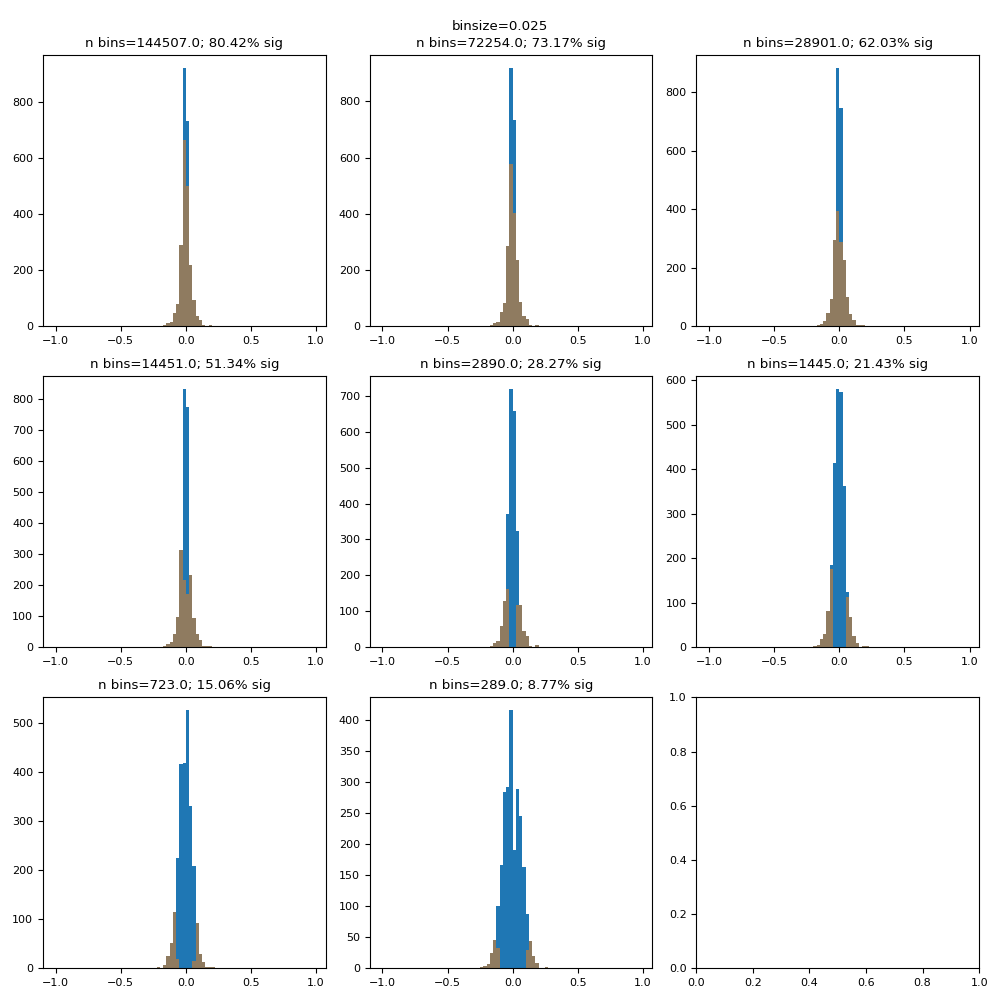

In [55]:
p_thresh=0.05
xbins=np.arange(-1,1,0.025)
pct_sig=[]
fig,ax=plt.subplots(3,3,figsize=(10,10))
ax=ax.flatten()
for ix,xx in enumerate(corr_by_stepsize):
    ax[ix].hist(corr_by_stepsize[xx][~np.isnan(corr_by_stepsize[xx])],bins=xbins,label=xx)
    ax[ix].hist(corr_by_stepsize[xx][corr_p_by_stepsize[xx]<p_thresh],bins=xbins,label=xx,alpha=0.5)
    temp_pct_sig=np.round(np.sum(corr_p_by_stepsize[xx]<p_thresh)/len(corr_p_by_stepsize[xx])*100,decimals=2)
    ax[ix].set_title('n bins='+str(np.round(len(timebins_table)/xx,decimals=0))+'; '+str(temp_pct_sig)+'% sig')
# ax.legend()
fig.suptitle('binsize='+str(binsize))
fig.tight_layout()

In [ ]:
# try corr by trial and change bin size

In [67]:
# try PCA on binned spike data

from sklearn.decomposition import PCA


In [107]:
# bin spike times (aligned to trials vs. not aligned to trials)
binsize=0.1
timebin_da,timebins_table=spike_utils.make_neuron_timebins_matrix(units, trials, binsize, generate_context_labels=True)

C:\Users\ethan.mcbride\Code\dynamic_routing_analysis\src\dynamic_routing_analysis\spike_utils.py:184: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['is_context_switch'].iloc[context_switches]=True


In [108]:
pca = PCA()
data_transformed = pca.fit_transform(timebin_da.T)

(-1.0, 20.0)

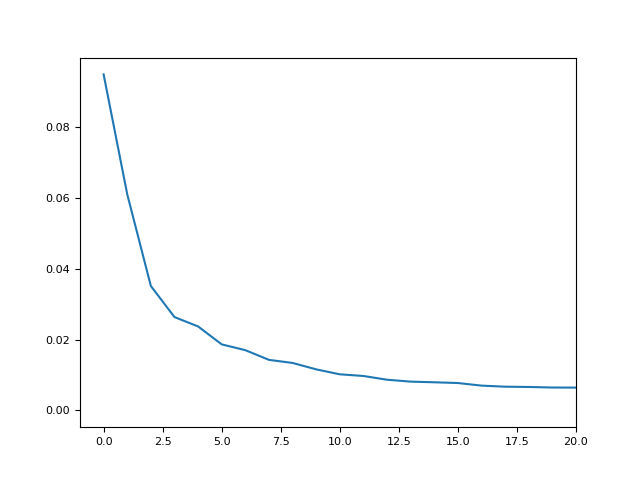

In [109]:
fig,ax=plt.subplots(1,1)
ax.plot(pca.explained_variance_ratio_)
ax.set_xlim([-1,20])

In [110]:
data_transformed.shape

(36436, 1478)

In [155]:
timebins_table.columns

Index(['bin_start', 'bin_end', 'bin_center', 'stim_start', 'stim_stop',
       'reward', 'is_vis_context', 'is_aud_context', 'is_vis_stim',
       'is_aud_stim', 'is_vis_target', 'is_aud_target', 'is_catch',
       'is_vis_nontarget', 'is_aud_nontarget', 'is_context_switch'],
      dtype='object')

Text(0.5, 1.0, 'r=-0.372; p=0.0')

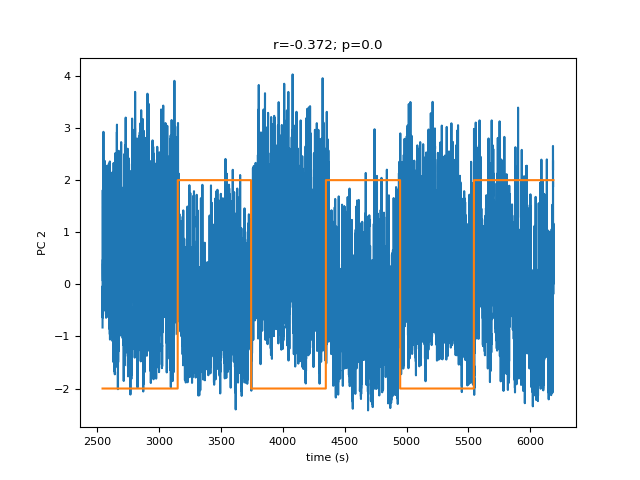

In [159]:
sel_feature=2
r,p=st.pearsonr(timebins_table['is_vis_context'],data_transformed[:,sel_feature])
fig,ax=plt.subplots(1,1)
ax.plot(timebins_table['bin_center'],data_transformed[:,sel_feature]/np.nanstd(data_transformed[:,sel_feature]))
ax.plot(timebins_table['bin_center'],timebins_table['is_vis_context']*4-2)
ax.set_ylabel('PC '+str(sel_feature))
ax.set_xlabel('time (s)')
ax.set_title('r='+str(np.round(r,decimals=3))+'; p='+str(np.round(p,decimals=3)))

In [133]:
r_all=[]
p_all=[]
for xx in range(data_transformed.shape[1]):
    r,p=st.pearsonr(timebins_table['is_vis_context'],data_transformed[:,xx])
    r_all.append(r)
    p_all.append(p)
r_all=np.array(r_all)
p_all=np.array(p_all)
# r,p=st.pearsonr(timebins_table['is_vis_context'],data_transformed[:,sel_feature])

(array([283.,  45.,  52.,  36.,  29.,  42.,  35.,  27.,  36.,  28.,  30.,
         29.,  14.,  23.,  36.,  20.,  20.,  19.,  24.,  24.,  13.,  25.,
         21.,  21.,  24.,  28.,  21.,  22.,  23.,  28.,  16.,  18.,  19.,
         16.,  15.,  24.,  27.,  15.,  18.,  24.,  21.,  17.,  15.,  25.,
         22.,  18.,  21.,  30.,  21.,  18.]),
 array([0.        , 0.01998933, 0.03997865, 0.05996798, 0.0799573 ,
        0.09994663, 0.11993595, 0.13992528, 0.1599146 , 0.17990393,
        0.19989325, 0.21988258, 0.2398719 , 0.25986123, 0.27985055,
        0.29983988, 0.3198292 , 0.33981853, 0.35980785, 0.37979718,
        0.3997865 , 0.41977583, 0.43976515, 0.45975448, 0.47974381,
        0.49973313, 0.51972246, 0.53971178, 0.55970111, 0.57969043,
        0.59967976, 0.61966908, 0.63965841, 0.65964773, 0.67963706,
        0.69962638, 0.71961571, 0.73960503, 0.75959436, 0.77958368,
        0.79957301, 0.81956233, 0.83955166, 0.85954098, 0.87953031,
        0.89951964, 0.91950896, 0.93949829, 0.

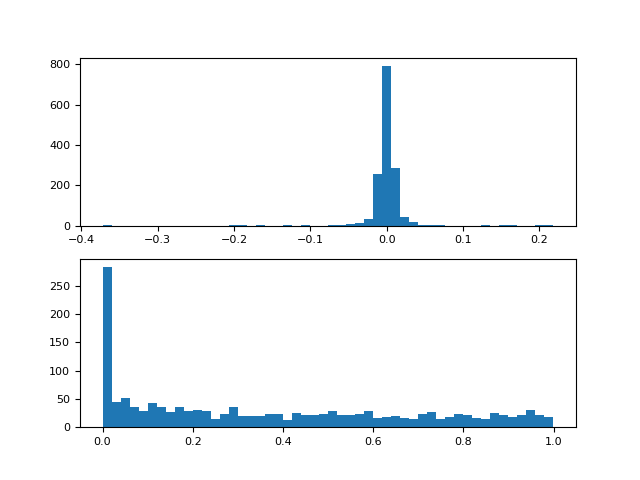

In [132]:
fig,ax=plt.subplots(2,1)
ax[0].hist(r_all,bins=50)
ax[1].hist(p_all,bins=50)

Text(0.5, 1.0, 'r=-0.163; p=0.0')

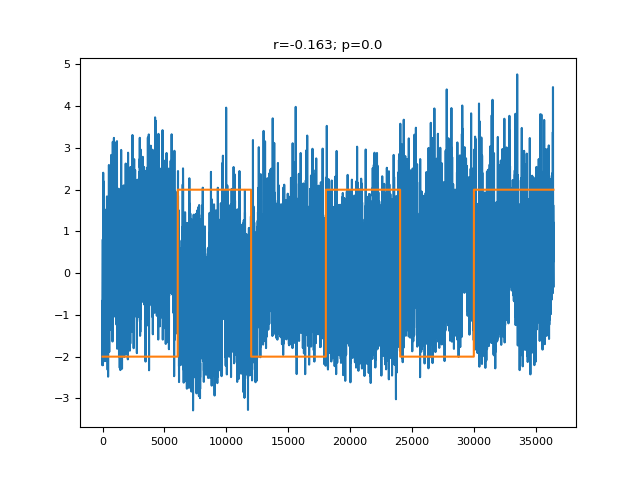

In [196]:
high_r_idx=np.where(np.abs(r_all)>0.1)[0]

sel_idx=4
r,p=st.pearsonr(timebins_table['is_vis_context'],data_transformed[:,high_r_idx[sel_idx]])
fig,ax=plt.subplots(1,1)
ax.plot(data_transformed[:,high_r_idx[sel_idx]]/np.nanstd(data_transformed[:,high_r_idx[sel_idx]]))
ax.plot(timebins_table['is_vis_context']*4-2)
ax.set_title('r='+str(np.round(r,decimals=3))+'; p='+str(np.round(p,decimals=3)))

In [197]:
pca_change=(
    np.mean(data_transformed[-100:,high_r_idx[sel_idx]])-
    np.mean(data_transformed[:100,high_r_idx[sel_idx]])
)
pca_change

68.06966846700323

In [198]:
np.mean(data_transformed[:100,high_r_idx[sel_idx]])


-10.177456544494996

In [195]:
pca_change_pct=pca_change/np.mean(data_transformed[:100,high_r_idx[sel_idx]])
pca_change_pct*100

-82.64944211588649

In [153]:
high_r_idx

array([ 0,  1,  2,  3,  6,  7,  8, 10, 11, 13, 17, 21, 25, 53],
      dtype=int64)

In [116]:
np.corrcoef(~timebins_table['is_vis_context'],data_transformed[:,sel_feature])[0,1]
st.pearsonr(timebins_table['is_vis_context'],data_transformed[:,sel_feature])

PearsonRResult(statistic=-0.37216065395887865, pvalue=0.0)

In [161]:
timebin_da.sel(timebin=slice(0,100)).mean(dim=['timebin','unit_id'])

<xarray.DataArray ()>
array(5.82564075)

In [169]:
fr_change=(
    timebin_da.sel(timebin=slice(len(timebin_da.timebin)-100,len(timebin_da.timebin))).mean(dim=['timebin','unit_id'])-
    timebin_da.sel(timebin=slice(0,100)).mean(dim=['timebin','unit_id'])
)
fr_change

<xarray.DataArray ()>
array(0.09729565)

In [191]:
fr_change_pct=fr_change/timebin_da.sel(timebin=slice(0,100)).mean(dim=['timebin','unit_id'])
fr_change_pct*100

<xarray.DataArray ()>
array(1.67012787)

In [204]:
fr_change_all_pct=(
    timebin_da.sel(timebin=slice(len(timebin_da.timebin)-100,len(timebin_da.timebin))).mean(dim=['timebin'])-
    timebin_da.sel(timebin=slice(0,100)).mean(dim=['timebin'])
)/timebin_da.sel(timebin=slice(0,100)).mean(dim=['timebin'])
fr_change_all_pct

<xarray.DataArray (unit_id: 1478)>
array([ 0.71910077, -0.37548873,         inf, ..., -0.06013658,
       -0.21759681, -0.14213381])
Coordinates:
  * unit_id  (unit_id) object '662892_2023-08-24_A-1025' ... '662892_2023-08-...

(array([  1.,   3.,   3.,  10.,  20., 104., 498., 428., 141.,  60.,  24.,
         19.,   9.,   6.,   7.,   5.,   4.,   2.,   2.,   1.,   2.,   1.,
          2.,   0.,   1.,   2.,   1.,   1.,   0.,   0.,   1.,   1.,   1.,
          1.,   0.,   1.,   1.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,
          0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

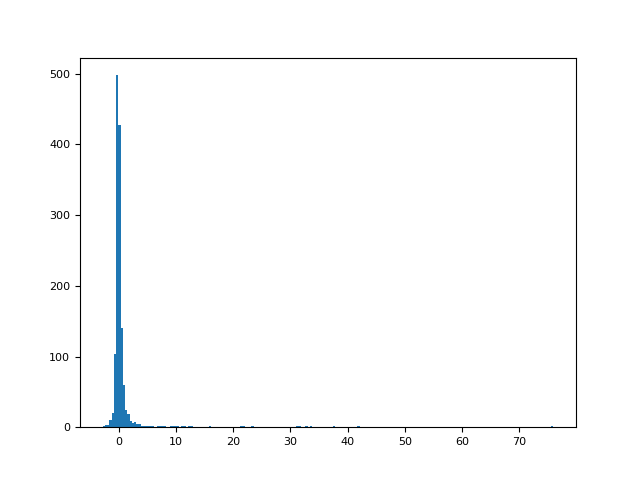

In [207]:
fig,ax=plt.subplots(1,1)
ax.hist(fr_change_all_pct.values[~np.isinf(fr_change_all_pct.values)],bins=200)

In [168]:
# per-unit changes?

